# Sistema recomendador

La idea es utilizar el dataset que se ha generado en el notebook Exploración-dataset-imdb y generar un modelo que combinará un sistema recomendador basado en contenido con el algorimo KMeans.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from joblib import dump, load

%matplotlib inline

In [2]:
!ls ./data

IMDb movies.csv        movies_clean.csv       movies_with_labels.csv


In [3]:
# Cargamos el dataset movies_clean.csv
df = pd.read_csv('./data/movies_clean.csv')

In [4]:
df.tail(5)

,id,title,genre,country,epoch,duration,known,description
19981,tt9831136,The Banana Splits Movie,"Comedy, Horror, Sci-Fi","USA, South Africa, Canada",current,short,unknown,A family attends a live taping of The Banana S...
19982,tt9860728,Falling Inn Love,"Comedy, Romance",USA,current,normal,unknown,When city girl Gabriela spontaneously enters a...
19983,tt9894470,VFW,"Action, Crime, Horror",USA,current,normal,unknown,A group of old war veterans put their lives on...
19984,tt9898858,Coffee & Kareem,"Action, Comedy",USA,current,short,unknown,Twelve-year-old Kareem Manning hires a crimina...
19985,tt9900782,Kaithi,"Action, Thriller",India,current,long,unknown,A recently released prisoner becomes involved ...


In [5]:
df.shape

(19986, 8)

La idea es combinar la columna genre, known y epoch para poder recomendar películas a los usuarios a partir del contenido de las palabras. Para ello utilizamos TfidfVectorizer de la librería sklearn, nos permite crear a partir de texto una matriz TF-IDF. Esta matriz que nos indica lo relevante que es cada palabra en el documento que aparece, dentro de la colección de documentos. Más información [aquí](https://es.wikipedia.org/wiki/Tf-idf)


In [6]:
# Lo primero que haremos será combinar las columnas genres y tags en una única columna llamada documents

def join_data(d):
    
    return f'''{str(d["genre"]).replace(",", " ").lower()} {d["epoch"]} {d['known']}'''


df['documents'] = df.apply(join_data, axis=1)

In [7]:
df['documents'].head()

0    adventure  drama  fantasy classic unknown
1    adventure  drama  history classic unknown
2                       comedy classic unknown
3            drama  history  war classic known
4               drama  romance classic unknown
Name: documents, dtype: object

In [8]:
# Instanciamos el proceso indicando que usamos el idioma inglés
tfidf = TfidfVectorizer(stop_words='english')

In [9]:
matrix = tfidf.fit_transform(df['documents'])

dump(matrix, './Models/tfidfvectorizer.joblib')

['./Models/tfidfvectorizer.joblib']

In [10]:
matrix.shape

(19986, 27)

### Generación del modelo KMeans

Una vez que tenemos la matriz creada, procedemos a crear el modelo de aprendizaje no supervisado KMeans. Primero debemos de comprobar cuál es el número de cluster adecuados para nuestro KMeans. Esto lo podemos hacer con silhouette_score

In [11]:
# Uso de silhouette para obtener el mejor número de clusters en función de nuestros datos
score_silhouette = list()

K = np.arange(2, 11, 1)
for k in K:
    #km = KMeans(n_clusters=k, n_init=10, random_state=42, init='k-means++', max_iter=300)
    km = MiniBatchKMeans(n_clusters=k, random_state=42, init='k-means++', batch_size=100)
    km = km.fit(matrix)
    score_silhouette.append(silhouette_score(matrix, km.labels_))

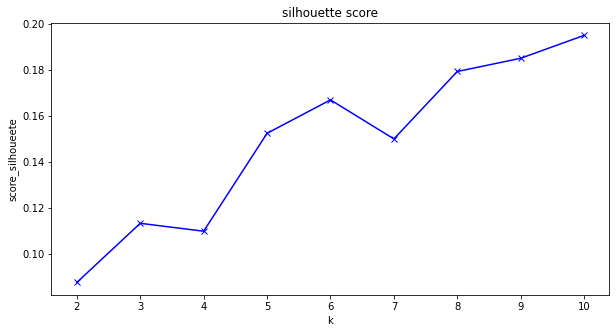

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(K, score_silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('score_silhoueete')
plt.xticks(K)
plt.title('silhouette score')
plt.show()

In [13]:
# Usamos como cluster k = 190
k = 10
kmeans = MiniBatchKMeans(n_clusters=k, random_state=12, init='k-means++', batch_size=100, n_init=3)
kmeans = kmeans.fit(matrix)
labels = kmeans.labels_

In [14]:
labels

array([0, 0, 0, ..., 7, 1, 2], dtype=int32)

In [15]:
len(labels)

19986

In [16]:
df['labels'] = labels

In [17]:
df.labels.value_counts()

0    3031
7    2737
3    2715
5    2114
9    1825
8    1786
1    1775
4    1569
2    1220
6    1214
Name: labels, dtype: int64

In [18]:
# Guardamos las películas con sus respectivas etiquetas
df.to_csv('./data/movies_with_labels.csv', header=True, index=False)

In [19]:
def get_label(text):
    
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf.fit(df['documents'])
   
    y = tfidf.transform([text])
    
    label_pred = kmeans.predict(y)
    
    return label_pred

l = get_label('action adventure known current sci-fi')

In [20]:
l[0]

6

In [21]:
def get_df_films(label, film):

    return df[((df['labels'] == label) | (df['title'] == film))].copy()

films = get_df_films(l[0], 'Spider-Man')

In [22]:
films.head(5)

,id,title,genre,country,epoch,duration,known,description,documents,labels
10,tt0011130,Dr. Jekyll and Mr. Hyde,"Drama, Horror, Sci-Fi",USA,classic,short,unknown,Dr. Henry Jekyll experiments with scientific m...,drama horror sci-fi classic unknown,6
59,tt0017136,Metropolis,"Drama, Sci-Fi",Germany,classic,long,known,In a futuristic city sharply divided between t...,drama sci-fi classic known,6
141,tt0022835,Dr. Jekyll and Mr. Hyde,"Horror, Sci-Fi",USA,classic,normal,unknown,Dr. Jekyll faces horrible consequences when he...,horror sci-fi classic unknown,6
149,tt0023194,The Mask of Fu Manchu,"Adventure, Horror, Sci-Fi",USA,classic,short,unknown,Englishmen race to find the tomb of Genghis Kh...,adventure horror sci-fi classic unknown,6
183,tt0024184,The Invisible Man,"Horror, Sci-Fi",USA,classic,short,known,"A scientist finds a way of becoming invisible,...",horror sci-fi classic known,6


In [23]:
films = films.drop_duplicates(subset=['title'], keep='last')
films = films.reset_index(drop=True)
films.shape

(1186, 10)

In [24]:
films.head()

,id,title,genre,country,epoch,duration,known,description,documents,labels
0,tt0017136,Metropolis,"Drama, Sci-Fi",Germany,classic,long,known,In a futuristic city sharply divided between t...,drama sci-fi classic known,6
1,tt0023194,The Mask of Fu Manchu,"Adventure, Horror, Sci-Fi",USA,classic,short,unknown,Englishmen race to find the tomb of Genghis Kh...,adventure horror sci-fi classic unknown,6
2,tt0024188,Island of Lost Souls,"Horror, Sci-Fi",USA,classic,short,unknown,An obsessed scientist conducts profane experim...,horror sci-fi classic unknown,6
3,tt0024216,King Kong,"Adventure, Horror, Sci-Fi",USA,classic,normal,known,A film crew goes to a tropical island for an e...,adventure horror sci-fi classic known,6
4,tt0026138,Bride of Frankenstein,"Drama, Horror, Sci-Fi",USA,classic,short,known,Mary Shelley reveals the main characters of he...,drama horror sci-fi classic known,6


In [25]:
def get_recommendation(dataframe, film):
    
    indice_movies = pd.Series(dataframe.index, index=dataframe['title'])

    tfidf2 = TfidfVectorizer(stop_words='english')
    matrix_tfidf = tfidf.fit_transform(dataframe['description'])

    cos_sim = cosine_similarity(matrix_tfidf, matrix_tfidf)

    scores = sorted(list(enumerate(cos_sim[indice_movies[film]])), key=lambda l: l[1], reverse=True)
    
    scores = scores[0:10]

    movie_indices = [f[0] for f in scores]

    return dataframe['title'].iloc[movie_indices]

In [27]:
r = get_recommendation(films, 'Spider-Man')

In [28]:
r.reset_index().drop('index', axis=1)

,title
0,Spider-Man
1,The Amazing Spider-Man
2,Spider-Man: Homecoming
3,Earth vs the Spider
4,Tammy and the T-Rex
5,Superhero Movie
6,Zapped!
7,Power Rangers
8,Weird Science
9,The Amazing Spider-Man 2


In [29]:
dump(kmeans, './Models/kmeans-films.joblib')

['./Models/kmeans-films.joblib']